In [6]:
import polars as pl
from schema import *


accounts = pl.read_parquet('overview.parquet')
accounts

creditor,instrument_type,amount,credit_type
str,str,f64,str
"""citybanamex""","""investment""",230000.0,null
"""banorte""","""credit""",172870.05,"""auto"""
"""infonavit_creditor""","""investment""",105243.65,null
"""bbva""","""credit""",96226.22,"""auto"""
"""citybanamex""","""credit""",53396.97,"""card"""
…,…,…,…
"""bbva""","""debit""",9866.31,null
"""self""","""debit""",5000.0,null
"""sivale""","""debit""",3288.41,null


In [2]:
@pl.api.register_dataframe_namespace("pre_plot")
class PrepareOverview(pl.DataFrame):
    def __init__(self, df: pl.DataFrame) -> None:
        super().__init__()
        self._df = df

    def add_cols(self) -> list[pl.DataFrame]:
        return self._df.fill_null(str()).with_columns(
            pl.concat_str(
                [
                    pl.col(creditor_cn),
                    # pl.col(instrument_type_cn),
                    pl.col(credit_type_cn),
                ],
                separator="\n",
            ).alias(account_label_cn),
            pl.when(pl.col(instrument_type_cn).eq(credit_instrument_cv)).then(pl.lit('red')).otherwise(pl.lit('green')).alias(color_cn)
        ).sort(amount_cn, descending=True)


debits = accounts.filter(
    (pl.col(instrument_type_cn) == debit_instrument_cv) |
     (pl.col(creditor_cn) == self_creditor_cv)
).with_row_index(row_index_cn).pre_plot.add_cols()
cash = debits[amount_cn].sum()

debts = accounts.filter(
    pl.col(instrument_type_cn) == credit_instrument_cv
).with_row_index(row_index_cn).pre_plot.add_cols()
debt = debts[amount_cn].sum()

investments = accounts.filter(
    (pl.col(instrument_type_cn) == investment_instrument_cv)
).with_row_index(row_index_cn).pre_plot.add_cols()
invested = debts[amount_cn].sum()


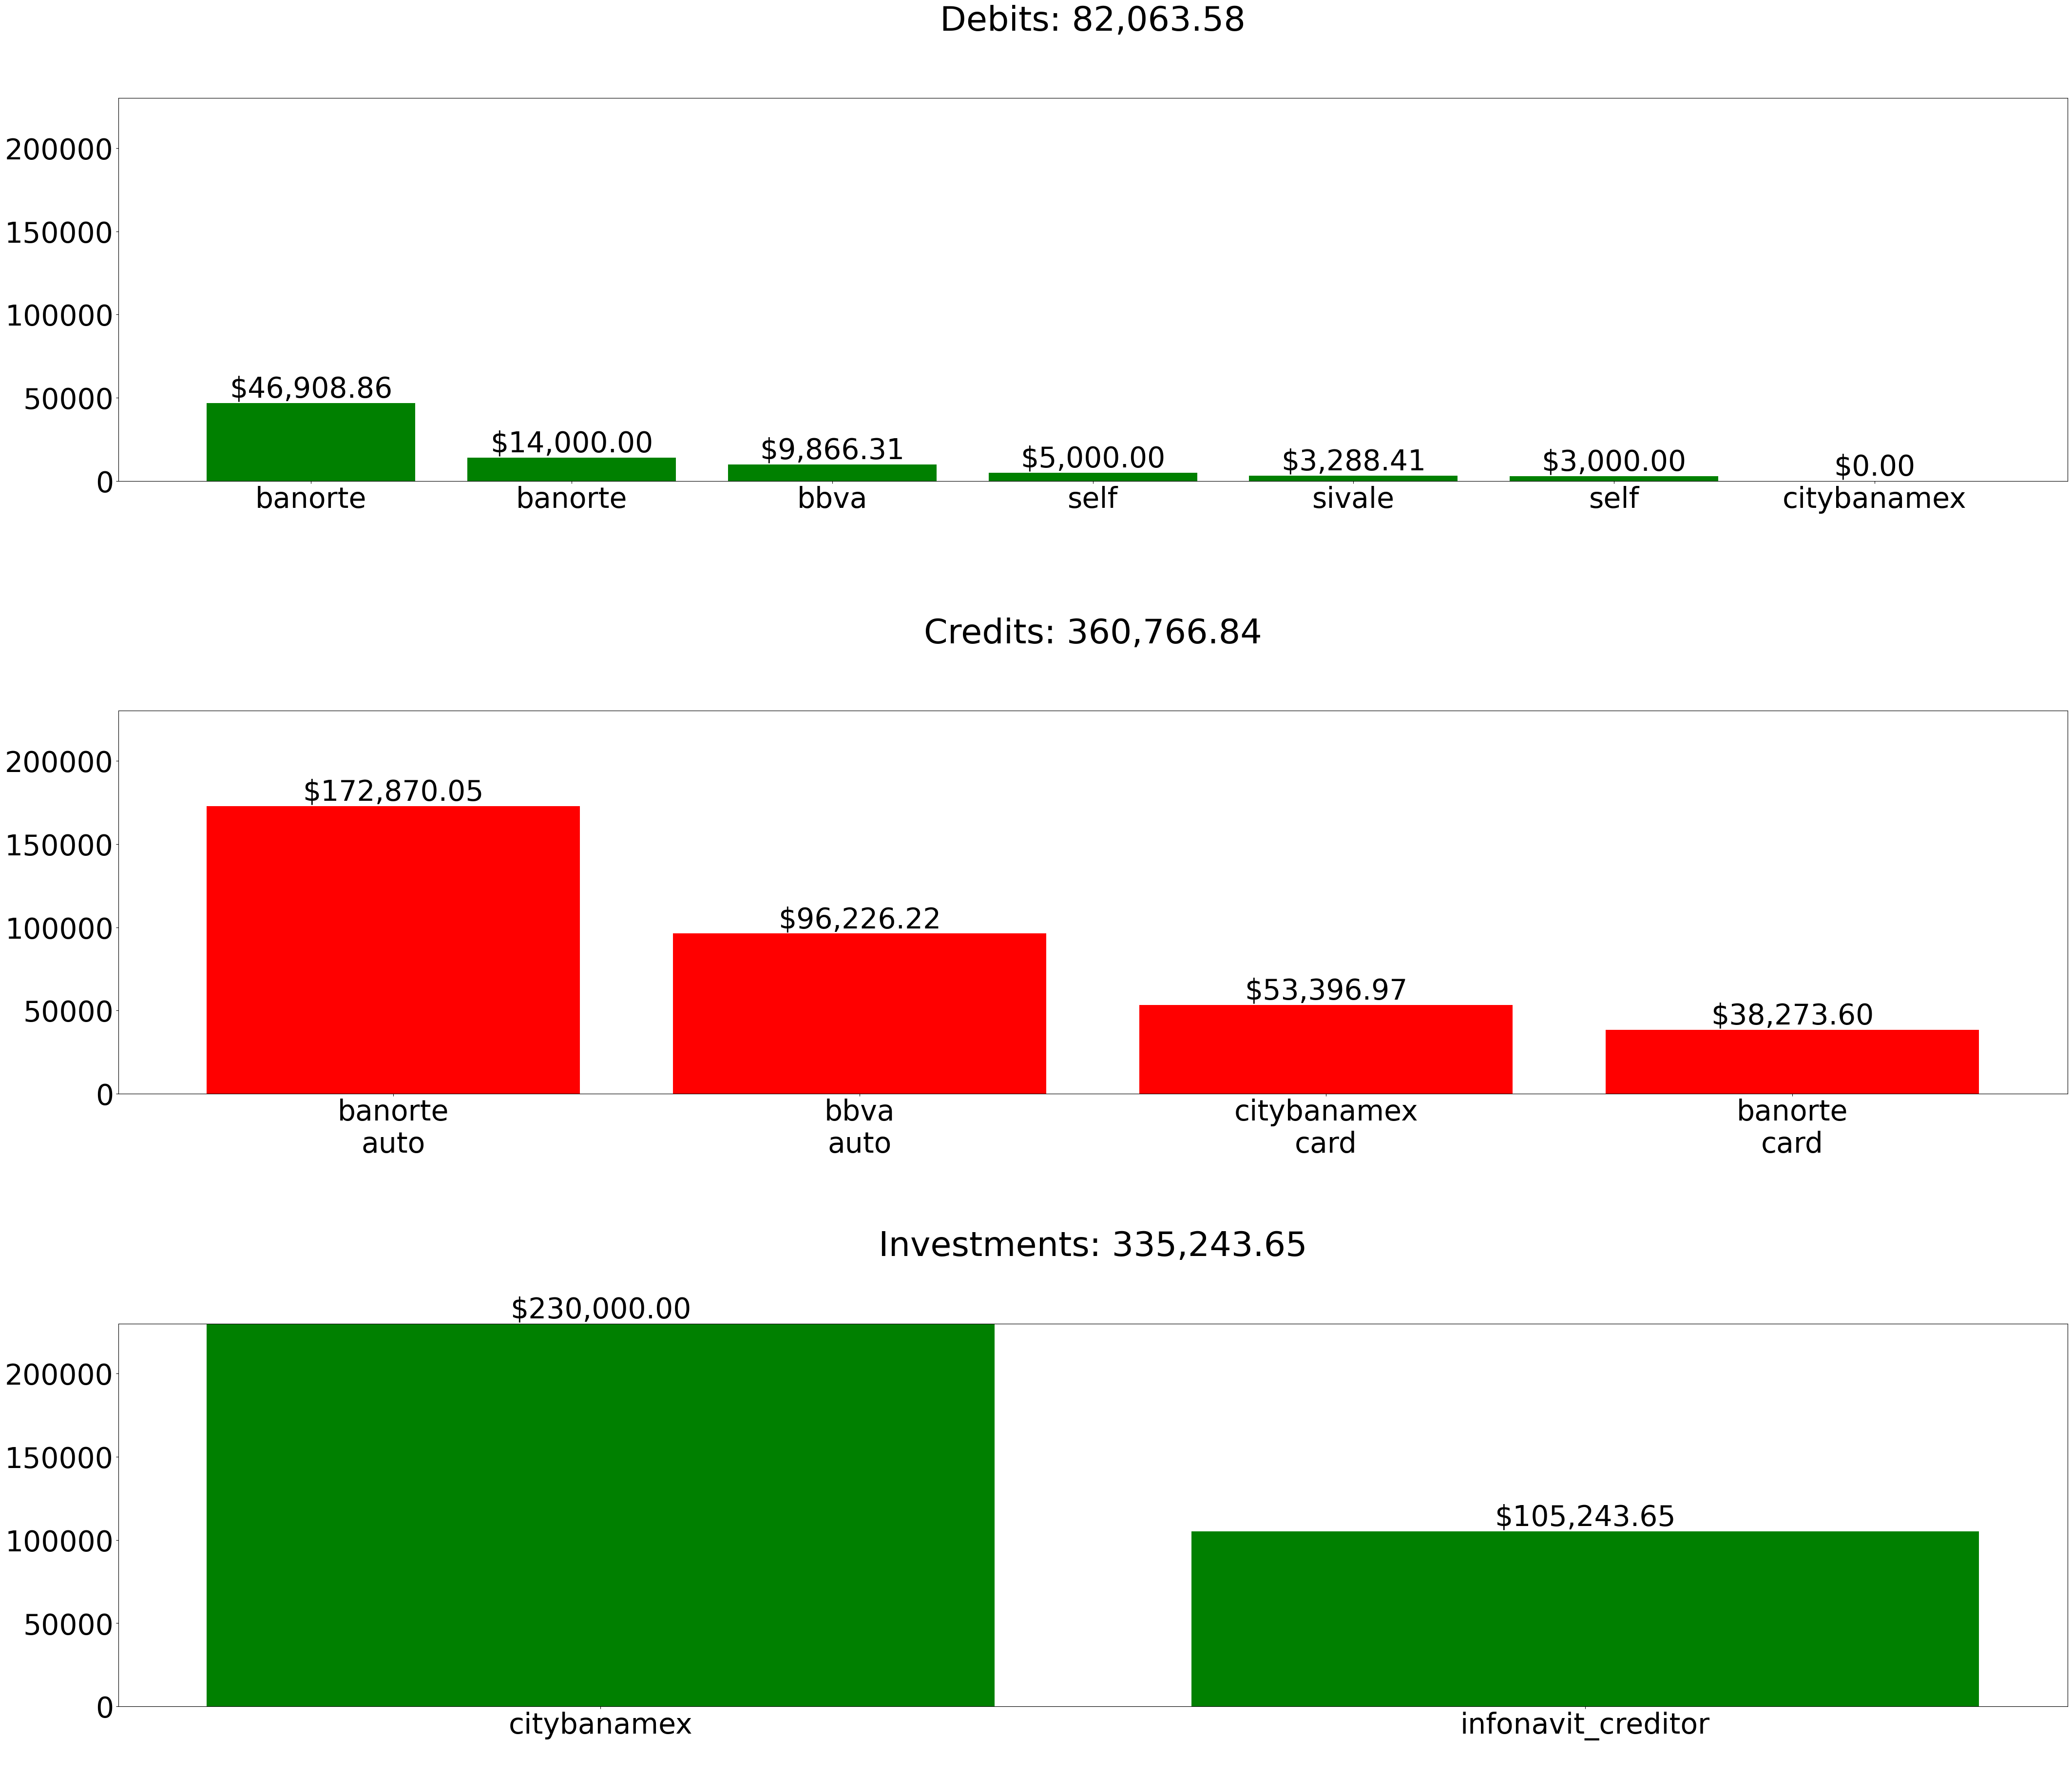

In [3]:
import matplotlib
from matplotlib import pyplot as plt


matplotlib.rcParams.update({'font.size': 42})

fig = plt.figure(figsize=(50, 30), layout='none')

# fig.set_constrained_layout(False)  # Disable constrained_layout
plt.subplots_adjust(
    left=0.1,    # left margin
    right=0.9,   # right margin
    bottom=0.1,  # bottom margin
    top=1.2,     # top margin
    wspace=0.4,  # width spacing between subplots
    hspace=0.6   # height spacing between subplots
)

debits_tile = "debits_tile"
credits_tile = "credits_tile"
investments_tile = "investments_tile"
axs = fig.subplot_mosaic([
    [debits_tile],
    [credits_tile],
    [investments_tile]
])

def currency_label(series: pl.Series) -> pl.Series:
    return series.map_elements(lambda x: f"${x:,.2f}", return_dtype=pl.String)




axs[debits_tile].set_title(f'Debits: {debits[amount_cn].sum():,.2f}', pad=100)
debit_bars = axs[debits_tile].bar(debits[row_index_cn], debits[amount_cn], color=debits[color_cn])
axs[debits_tile].bar_label(debit_bars, labels=currency_label(debits[amount_cn]))
axs[debits_tile].set_xticks( debits[row_index_cn], debits[account_label_cn])
axs[debits_tile].set_ylim(accounts[amount_cn].min(), accounts[amount_cn].max())

axs[credits_tile].set_title(f'Credits: {debts[amount_cn].sum():,.2f}', pad=100)
credit_bars = axs[credits_tile].bar(debts[row_index_cn], debts[amount_cn], color=debts[color_cn])
axs[credits_tile].bar_label(credit_bars, labels=currency_label(debts[amount_cn]))
axs[credits_tile].set_xticks( debts[row_index_cn], debts[account_label_cn])
axs[credits_tile].set_ylim(accounts[amount_cn].min(), accounts[amount_cn].max())

axs[investments_tile].set_title(f'Investments: {investments[amount_cn].sum():,.2f}', pad=100)
bars = axs[investments_tile].bar(investments[row_index_cn], investments[amount_cn], color=investments[color_cn])
axs[investments_tile].bar_label(bars, labels=currency_label(investments[amount_cn]))
axs[investments_tile].set_xticks( investments[row_index_cn], investments[account_label_cn])
axs[investments_tile].set_ylim(accounts[amount_cn].min(), accounts[amount_cn].max())




plt.show()